In [56]:
import pandas as pd
import json
import glob
import os
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

%matplotlib inline

In [2]:
def read_formatted_jsons(INDIR):
    generation_dfs = []
    stats_dicts = []
    
    for domain in os.listdir(INDIR):
        for fname in glob.glob(INDIR+domain+"/*.json"):

            org_id = os.path.basename(fname).strip(".json")

            with open(fname) as f:
                datajson = json.load(f)

            datajson["stats"]["org_id"] = org_id
            datajson["stats"]["domain"] = domain
            datajson["stats"]["path"] = fname

            stats_dicts.append(datajson["stats"])
            generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

In [3]:
def read_formatted_json_single(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
        datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

### Transpose etc.

In [4]:
def twist_dfs(df_list):
    twisted_dfs = []
    for df in df_list:
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()   
        twisted_dfs.append(df)
    return twisted_dfs

### Add `n` columns

In [5]:
def add_n_to_cols(df_list):
    for df in df_list:
        original_columns = df.columns
        for col in original_columns:
            df["n_"+col] = df[col].str.len() 
    return df_list

### Add domain and org_id

In [6]:
def add_domain_and_orgid(df_list,stats_dicts):
    for i,df in enumerate(df_list):
        df['org_id'] = stats_dicts[i]["org_id"]
        df['domain'] = stats_dicts[i]["domain"]
    return df_list

### Add tags if desired

In [7]:
def add_tags(df_list,cpds_to_tag):
    for df in df_list:
        df['tags'] = df['compounds_new'].apply(lambda x: [cpd for cpd in cpds_to_tag if cpd in x])
    return df_list

### Load metadata

In [14]:
def load_json(fname):
    with open(fname) as f:
        return json.load(f)

### Main

In [8]:
cpds_to_tag = []

INDIR = "../results/formatted/ph_edge_jsons/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [9]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00014, C00011, C00697, C00067, C0046...","[C00282, C00237, C00014, C00011, C00067, C0069...","[R10092, R00131, R00602, R00132]","[R00131, R00132, R00602, R10092]",[],[],10,10,4,4,0,0,2506520044,archaea
2,"[C00080, C00001, C00014, C00288, C00011, C0069...","[C00080, C00288, C00086, C00027, C01353]","[R10092, R06154, R00131, R00602, R00132, R00009]","[R06154, R00009]",[],[],15,5,6,2,0,0,2506520044,archaea
3,"[C00007, C00080, C00001, C00014, C00288, C0001...","[C00007, C00218]","[R10092, R06154, R00275, R00131, R00602, R0013...",[R00275],[],[],17,2,7,1,0,0,2506520044,archaea
4,"[C00007, C00080, C00001, C00014, C00288, C0001...",[C00704],"[R10092, R06154, R00275, R00131, R00602, R0013...",[],[],[],18,1,7,0,0,0,2506520044,archaea
1,"[C00001, C00011, C00014, C00067, C00469, C0028...","[C00237, C00014, C00011, C00067, C00132, C0028...","[R10092, R00602, R00132]","[R00132, R00602, R10092]",[],[],8,8,3,3,0,0,2506783009,archaea


In [10]:
len(stats_dicts)

294

In [29]:
ph_archaea_ids = [i["org_id"] for i in stats_dicts if i["domain"]=="archaea"]

In [31]:
len(ph_archaea_ids)

28

In [111]:
archaea_metadata = load_json("../jgi/metadata/archaea_metadata.json")
bacteria_metadata = load_json("../jgi/metadata/bacteria_metadata_subset.json")

In [19]:
[len(k["records"]) for k in archaea_metadata]

TypeError: string indices must be integers

In [21]:
[k for k in archaea_metadata]

[u'sort',
 u'totalRecords',
 u'checked',
 u'pageSize',
 u'recordsReturned',
 u'records',
 u'startIndex',
 u'filtChecked',
 u'allSelect',
 u'dir']

In [112]:
ph_archaea_records = [i for i in archaea_metadata["records"] if i['IMGGenomeIDDisp'] in ph_ids]
ph_bacteria_records = [i for i in bacteria_metadata["records"] if i['IMGGenomeIDDisp'] in ph_ids]

In [27]:
len(ph_archaea_records)

28

In [35]:
[i['KEGGassembledDisp'] for i in ph_archaea_records]

[u'25.29',
 u'28.36',
 u'22.33',
 u'30.96',
 u'23.01',
 u'26.86',
 u'22.78',
 u'31.54',
 u'24.02',
 u'27.15',
 u'23.57',
 u'24.77',
 u'23.66',
 u'26.65',
 u'24.47',
 u'26.47',
 u'32.18',
 u'22.43',
 u'27.63',
 u'28.39',
 u'23.94',
 u'21.8',
 u'22.84',
 u'23.06',
 u'28.49',
 u'30.29',
 u'9.11',
 u'23.31']

#### % of genes with coded KEGG entries in assembled genomes

(array([ 1.,  0.,  0.,  0.,  0.,  5.,  9.,  5.,  4.,  4.]),
 array([  9.11 ,  11.417,  13.724,  16.031,  18.338,  20.645,  22.952,
         25.259,  27.566,  29.873,  32.18 ]),
 <a list of 10 Patch objects>)

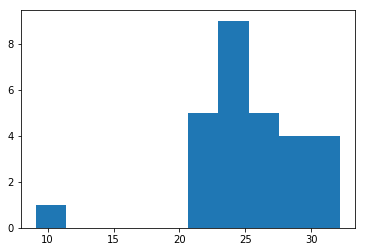

In [37]:
plt.hist([float(i['KEGGassembledDisp']) for i in ph_archaea_records])

(array([  39.,  333.,  972.,  271.,    9.,    0.,    0.,    0.,    0.,    1.]),
 array([   3.18 ,   12.862,   22.544,   32.226,   41.908,   51.59 ,
          61.272,   70.954,   80.636,   90.318,  100.   ]),
 <a list of 10 Patch objects>)

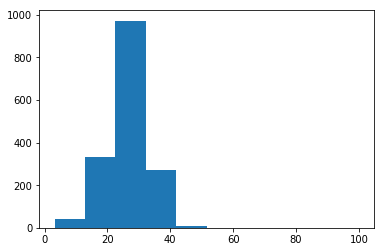

In [38]:
plt.hist([float(i['KEGGassembledDisp']) for i in archaea_metadata["records"]])

#### % of coding bases in assembled genomes

In [42]:
[i['CodingBaseCountassembled125'] for i in ph_archaea_records]

[u'93.38',
 u'92.73',
 u'82.39',
 u'86.59',
 u'86.05',
 u'89.25',
 u'81.21',
 u'87.27',
 u'86.29',
 u'95.38',
 u'82.65',
 u'82.8',
 u'83.08',
 u'84.55',
 u'84.22',
 u'90.58',
 u'94.82',
 u'82.31',
 u'90.32',
 u'91.63',
 u'94.55',
 u'85.06',
 u'91.18',
 u'86.95',
 u'92.15',
 u'90.04',
 u'83.17',
 u'82.59']

(array([ 4.,  4.,  3.,  3.,  2.,  1.,  3.,  3.,  2.,  3.]),
 array([ 81.21 ,  82.627,  84.044,  85.461,  86.878,  88.295,  89.712,
         91.129,  92.546,  93.963,  95.38 ]),
 <a list of 10 Patch objects>)

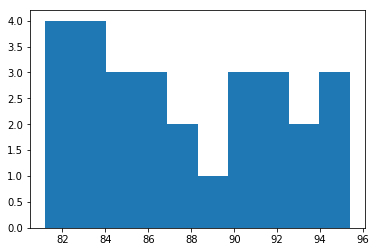

In [44]:
plt.hist([float(i['CodingBaseCountassembled125']) for i in ph_archaea_records])

(array([   1.,    0.,    0.,    0.,    0.,    0.,    2.,  115.,  607.,  900.]),
 array([  0.84 ,  10.539,  20.238,  29.937,  39.636,  49.335,  59.034,
         68.733,  78.432,  88.131,  97.83 ]),
 <a list of 10 Patch objects>)

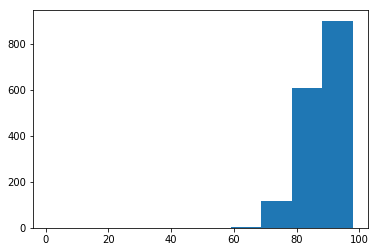

In [45]:
plt.hist([float(i['CodingBaseCountassembled125']) for i in archaea_metadata["records"]])

#### Number of archaea that each scope compound is in

In [48]:
ph_archaea_stats_dicts =[i for i in stats_dicts if i["domain"]=="archaea"]

In [ ]:
[i["scope_compounds"] for i in ph_archaea_stats_dicts]

In [54]:
all_ph_archaea_scope_compounds = [c for i in ph_archaea_stats_dicts for c in i["scope_compounds"]]

In [55]:
len(all_ph_archaea_scope_compounds)

23850

In [60]:
len(collections.Counter(all_ph_archaea_scope_compounds))

1610

In [61]:
len(set(all_ph_archaea_scope_compounds))

1610

(array([ 280.,  154.,   79.,   43.,  204.,  158.,  119.,  140.,  149.,  284.]),
 array([  1. ,   3.7,   6.4,   9.1,  11.8,  14.5,  17.2,  19.9,  22.6,
         25.3,  28. ]),
 <a list of 10 Patch objects>)

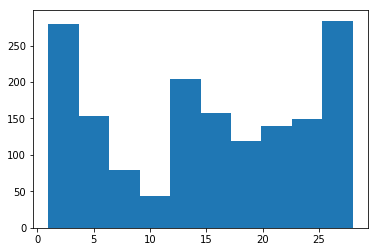

In [59]:
## y-axis: number of unique compounds
## x-axis: number of ph archaea that have y-unique compounds.
## eg. there are approx 275 compounds that only show up in 1 species (left side of plot)
## and approx 50 compounds that only show up in 10 species (low point of histogram)
plt.hist(collections.Counter(all_ph_archaea_scope_compounds).values())

#### molecular weight of compounds

In [62]:
kegg_compounds = load_json("../kegg/2018-09-25/compound.json")

In [77]:
kegg_masses = dict()
cdir = "../kegg/2018-09-25/compound/"
for fname in os.listdir(cdir):
    cjson = load_json(cdir+fname)
    kegg_masses[cjson[0]['entry_id']] = float(cjson[0]['exact_mass'])

In [79]:
len(kegg_masses)

18181

In [80]:
kegg_masses_ph_archaea_only = dict()
for i in all_ph_archaea_scope_compounds:
    kegg_masses_ph_archaea_only[i] = kegg_masses[i]

In [81]:
len(kegg_masses_ph_archaea_only)

1610

In [82]:
kegg_masses_ph_archaea_only

{u'C01028': 162.1004,
 u'C04506': 0.0,
 u'C01755': 58.983,
 u'C01024': 854.2858,
 u'C04500': 0.0,
 u'C04501': 301.0563,
 u'C04874': 255.0968,
 u'C16389': 1121.3711,
 u'C16684': 0.0,
 u'C16685': 0.0,
 u'C16688': 422.0825,
 u'C00555': 87.0684,
 u'C02130': 384.1268,
 u'C02133': 0.0,
 u'C02137': 150.0317,
 u'C07213': 122.0732,
 u'C09820': 971.1575,
 u'C14463': 146.0579,
 u'C01330': 22.9898,
 u'C00552': 150.0164,
 u'C01335': 0.0,
 u'C05839': 326.1002,
 u'C05838': 164.0473,
 u'C06232': 163.9007,
 u'C05357': 0.0,
 u'C01935': 0.0,
 u'C05909': 322.0689,
 u'C01931': 0.0,
 u'C01240': 0.0,
 u'C02225': 206.0427,
 u'C02226': 130.0266,
 u'C02593': 977.3136,
 u'C18802': 905.3056,
 u'C17560': 0.0,
 u'C17561': 0.0,
 u'C03069': 849.1571,
 u'C06585': 222.0448,
 u'C06586': 220.0291,
 u'C03263': 660.3159,
 u'C02047': 0.0,
 u'C06567': 0.0,
 u'C03082': 213.0038,
 u'C06560': 145.0155,
 u'C16361': 210.0753,
 u'C16362': 200.0909,
 u'C04272': 134.0579,
 u'C08325': 457.1584,
 u'C03402': 0.0,
 u'C17962': 167.0347,


In [83]:
len([i for i in kegg_masses_ph_archaea_only if kegg_masses_ph_archaea_only[i]==0.0])

361

In [93]:
tups = [("c",90),("a",119),("f",80)]

In [97]:
sorted(tups, key=lambda x: x[1], reverse=True)

[('a', 119), ('c', 90), ('f', 80)]

In [98]:
xs

[9, 5, 4, 3, 3, 2, 1]

In [103]:
xs.pop(0)

9

In [107]:
stats_dicts[0]['scope_compounds']

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [131]:
all_ph_archaea_scope_compounds

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [113]:
collections.Counter([i['EcosystemCategory'] for i in ph_archaea_records])

Counter({u'Aquatic': 24, u'Terrestrial': 1, u'Wastewater': 1, u'zzz': 2})

In [116]:
collections.Counter([i['Habitat'] for i in ph_archaea_records])

Counter({u'Aquatic, Fresh water': 4,
         u'Aquatic, Fresh water, Saline water': 1,
         u'Aquatic, Fresh water, Sediment': 4,
         u'Aquatic, Fresh water, Soil': 1,
         u'Aquatic, Hot spring, Hydrothermal vent': 1,
         u'Aquatic, Hot spring, Hydrothermal vent, Marine': 1,
         u'Aquatic, Soda lakes': 1,
         u'Fresh water, Aquatic': 1,
         u'Hot spring': 1,
         u'Marine, Sediment': 1,
         u'hot spring sediment': 11,
         u'zzz': 1})

In [122]:
collections.Counter([i['Habitat'] for i in ph_bacteria_records])

Counter({u'Air': 3,
         u'Alkaline water': 1,
         u'Alkaline water, Soda lake': 1,
         u'Aquatic': 7,
         u'Aquatic, Deep sea, Marine': 1,
         u'Aquatic, Deep sea, Marine, Sediment': 4,
         u'Aquatic, Fresh water': 11,
         u'Aquatic, Fresh water, Host': 1,
         u'Aquatic, Fresh water, Hot spring': 2,
         u'Aquatic, Fresh water, Lake': 2,
         u'Aquatic, Fresh water, Lake, Soda lakes': 1,
         u'Aquatic, Fresh water, Marine': 1,
         u'Aquatic, Fresh water, Mud': 1,
         u'Aquatic, Fresh water, Sediment': 3,
         u'Aquatic, Fresh water, Sediment, Soda lakes': 3,
         u'Aquatic, Fresh water, Soil': 1,
         u'Aquatic, Host': 2,
         u'Aquatic, Host, Insect': 1,
         u'Aquatic, Host, Marine': 5,
         u'Aquatic, Hot spring': 5,
         u'Aquatic, Hot spring, Sediment': 2,
         u'Aquatic, Hypersaline lakes': 1,
         u'Aquatic, Marine': 1,
         u'Aquatic, Marine, Sea water': 14,
         u'Aquatic

In [127]:
bact_habitat_counter = collections.Counter([i['Habitat'] for i in ph_bacteria_records])
n_aquatic = 0
for i in bact_habitat_counter:
    if 'Aquatic' in i:
        n_aquatic+= bact_habitat_counter[i]

In [130]:
sum(bact_habitat_counter.values())

266

In [129]:
n_aquatic

101

In [119]:
collections.Counter([i['EnergySource'] for i in ph_archaea_records])

Counter({u'Chemoorganotroph': 10,
         u'Heterotroph': 1,
         u'Organotroph': 2,
         u'zzz': 15})

In [118]:
collections.Counter([i['EnergySource'] for i in ph_bacteria_records])

Counter({u'Chemoautotroph': 1,
         u'Chemoheterotroph': 20,
         u'Chemoheterotroph, Photoautotroph': 1,
         u'Chemolithoautotroph': 1,
         u'Chemolithotroph': 1,
         u'Chemoorganoheterotroph': 2,
         u'Chemoorganotroph': 27,
         u'Chemoorganotroph, Heterotroph': 2,
         u'Heterotroph': 31,
         u'Lithoheterotroph': 1,
         u'Methylotroph': 1,
         u'Phototroph': 1,
         u'zzz': 177})

In [115]:
bacteria_metadata["records"][0].keys()

[u'SalinityConcentration',
 u'pHDisp',
 u'GenomeNameSampleName',
 u'HabitatDisp',
 u'GenomeNameSampleNameDisp',
 u'pH',
 u'GenomeSizeassembledDisp',
 u'StudyNameDisp',
 u'IMGGenomeIDDisp',
 u'SequencingCenterDisp',
 u'DomainDisp',
 u'SalinityConcentrationDisp',
 u'SequencingStatus',
 u'GeneCountassembled',
 u'SalinityDisp',
 u'Salinity',
 u'SequencingStatusDisp',
 u'GeneCountassembledDisp',
 u'Domain',
 u'EnergySourceDisp',
 u'_img_yuirow_id',
 u'Habitat',
 u'EnergySource',
 u'SequencingCenter',
 u'GenomeSizeassembled',
 u'StudyName',
 u'IMGGenomeID',
 u'Select']

In [23]:
archaea_metadata["records"][0].keys()

[u'Enzymeassembled',
 u'IMGProductAssignment',
 u'MetaCycCountassembled',
 u'ContactNameDisp',
 u'BiosyntheticClusterGeneassembledDisp',
 u'ProportalWOASalinity',
 u'GenomeProperty',
 u'SampleBodySubsiteDisp',
 u'SpecificEcosystem',
 u'COGClusterCountassembledDisp',
 u'RevisedCountDisp',
 u'GOLDSequencingProjectIDDisp',
 u'SampleBodySiteDisp',
 u'DomainDisp',
 u'Sporulation',
 u'UncharCountDisp',
 u'FundingProgram',
 u'PfamClusterCountassembledDisp',
 u'GOLDAnalysisProjectID',
 u'ITSSPIDDisp',
 u'Comments',
 u'MetabolismDisp',
 u'RNAassembled',
 u'SporulationDisp',
 u'SequencingCenter',
 u'JGIProjectIDITSSPIDDisp',
 u'Select',
 u'CodingBaseCountNP127',
 u'Alt2ContactEmails',
 u'KOGCountDisp',
 u'BioticRelationshipsDisp',
 u'KOGCount',
 u'CladeDisp',
 u'TransmembraneCount',
 u'MyIMGAnnotation',
 u'23SrRNACountassembledDisp',
 u'wFuncPredCountassembled',
 u'NitrateConcentrationDisp',
 u'ProportalIsolation',
 u'HostGender',
 u'ProportalOcean',
 u'NCBIProjectIDDisp',
 u'GOLDSequencingDepth

### Look at some properties of stats dicts

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,  11.6,
         12.8,  14. ]),
 <a list of 10 Patch objects>)

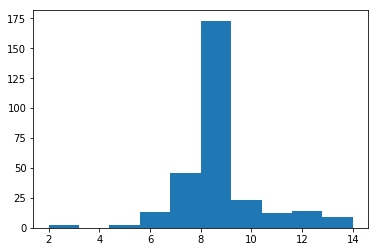

In [130]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

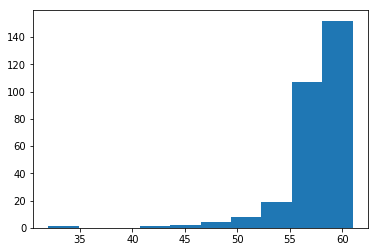

In [131]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

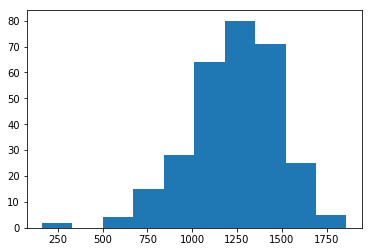

In [132]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

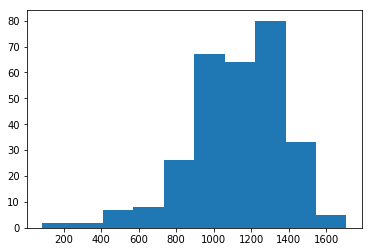

In [133]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

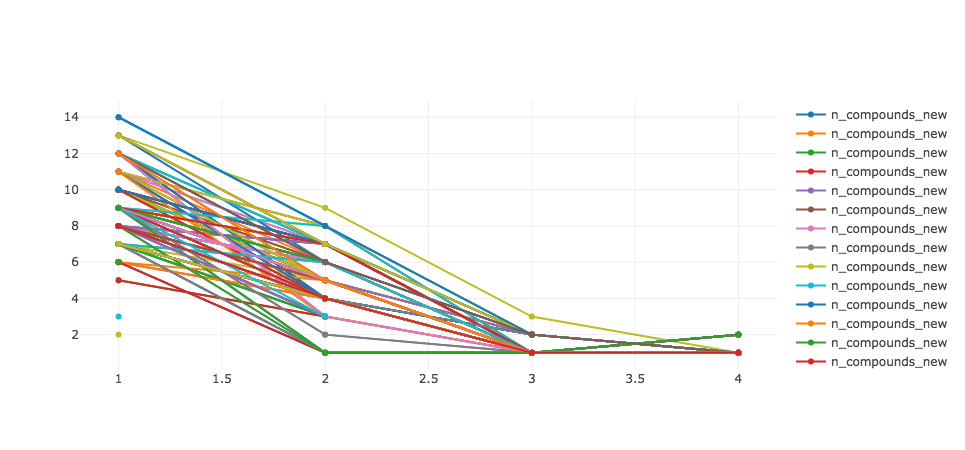

In [134]:
cool_plots_many(df,'n_compounds_new')

## Check seeds that contain phosphorous

In [135]:
INDIR = "../results/formatted/ph_edge_jsons_P/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [136]:
stats_dicts[0].keys()

['domain',
 u'scope_seeds',
 u'scope_targets',
 'org_id',
 u'scope_compounds',
 'path',
 u'scope_reactions']

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  3. ,   4.2,   5.4,   6.6,   7.8,   9. ,  10.2,  11.4,  12.6,
         13.8,  15. ]),
 <a list of 10 Patch objects>)

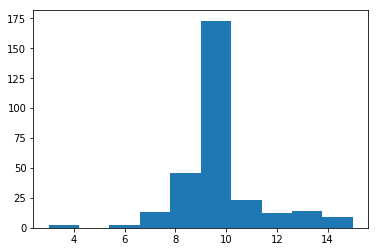

In [137]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

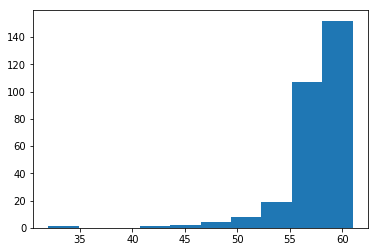

In [138]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

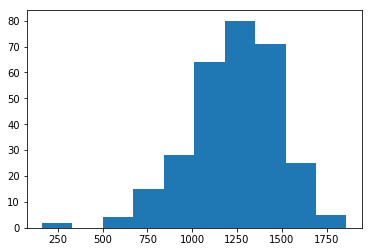

In [139]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

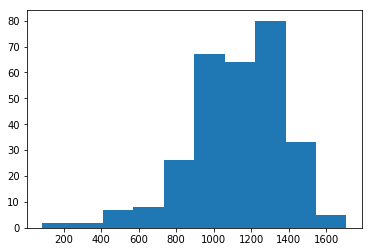

In [140]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

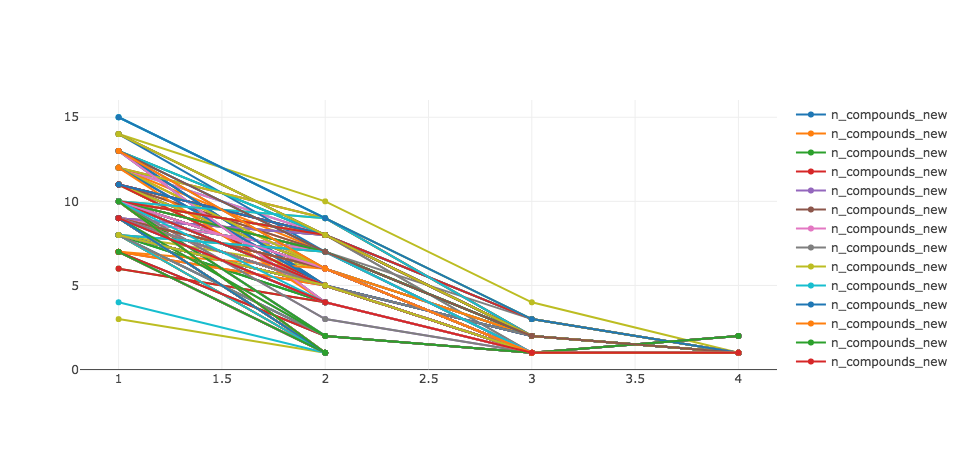

In [141]:
cool_plots_many(df,'n_compounds_new')

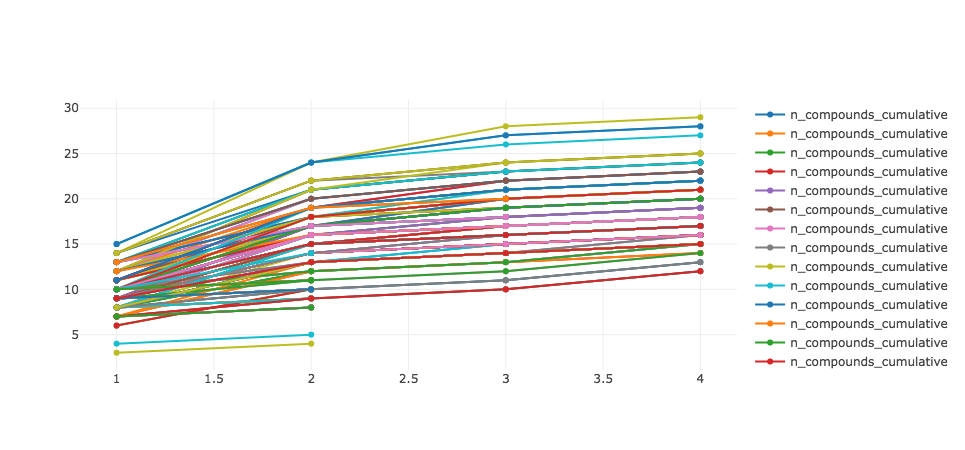

In [142]:
cool_plots_many(df,'n_compounds_cumulative')

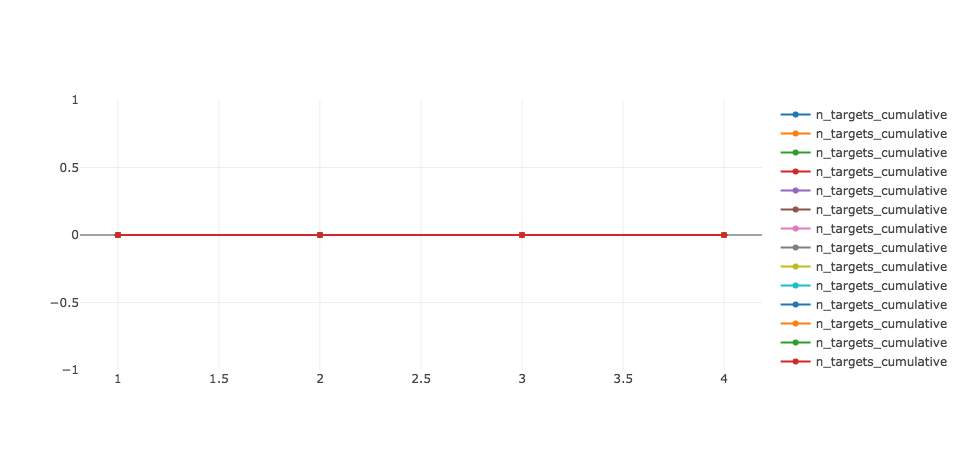

In [143]:
cool_plots_many(df,'n_targets_cumulative')

## Reversed expansions

In [144]:
INDIR = "../results/formatted/ph_edge_jsons_reversed/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [153]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00016, C00002, C00065, C00004, C00001, C0000...","[C00075, C00006, C00001, C00360, C00003, C0000...","[R00782, R00243, R00093, R10348, R00114, R0075...","[R00236, R00114, R00516, R02094, R00963, R0015...",[C00001],[C00001],56,56,73,73,1,1,2506520044,archaea
2,"[C00016, C00299, C00009, C00002, C00026, C0006...","[C00299, C00009, C00026, C00048, C00080, C0001...","[R01876, R02331, R00143, R00253, R00782, R0024...","[R01876, R02331, R00143, R00253, R02097, R1009...","[C00001, C00014, C00011, C00283]","[C00014, C00011, C00283]",109,53,196,123,4,3,2506520044,archaea
3,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C01346, C14818, C00288, C01103, C00957, C0045...","[R01876, R02331, R09186, R01388, R00143, R0107...","[R09186, R01388, R01072, R01870, R02323, R0104...","[C00001, C00014, C00011, C00067, C00469, C00283]","[C00067, C00469]",192,83,287,91,6,2,2506520044,archaea
4,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C03826, C00258, C03090, C01185, C00117, C0026...","[R01876, R02331, R09186, R01388, R00143, R0107...","[R03348, R01776, R01083, R01395, R05605, R0224...","[C00001, C00014, C00011, C00067, C00469, C0028...",[C00132],249,57,350,63,7,1,2506520044,archaea
5,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C00007, C03794, C00898, C00081, C01563, C0444...","[R01876, R02331, R09186, R01388, R00143, R0007...","[R00078, R01859, R06180, R00970, R07456, R0694...","[C00001, C00014, C00011, C00067, C00469, C0028...",[],300,51,404,54,7,0,2506520044,archaea


(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 33. ,  35.9,  38.8,  41.7,  44.6,  47.5,  50.4,  53.3,  56.2,
         59.1,  62. ]),
 <a list of 10 Patch objects>)

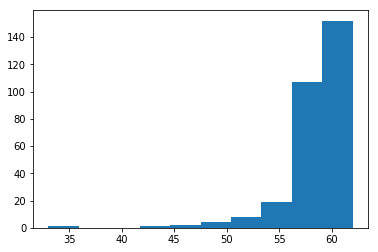

In [145]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,  11.6,
         12.8,  14. ]),
 <a list of 10 Patch objects>)

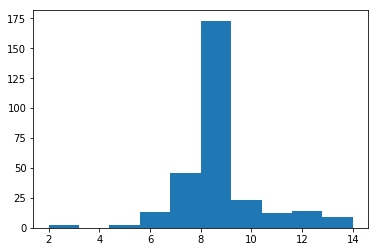

In [146]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

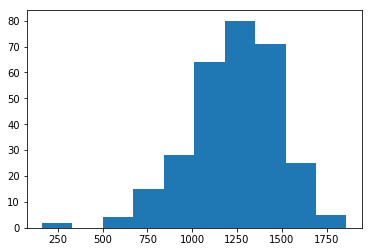

In [147]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

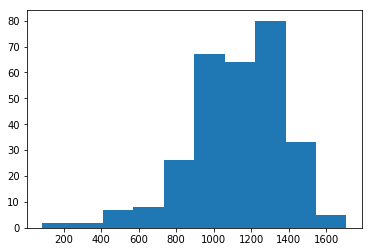

In [148]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

In [152]:
# cool_plots_many(df,'n_compounds_new')

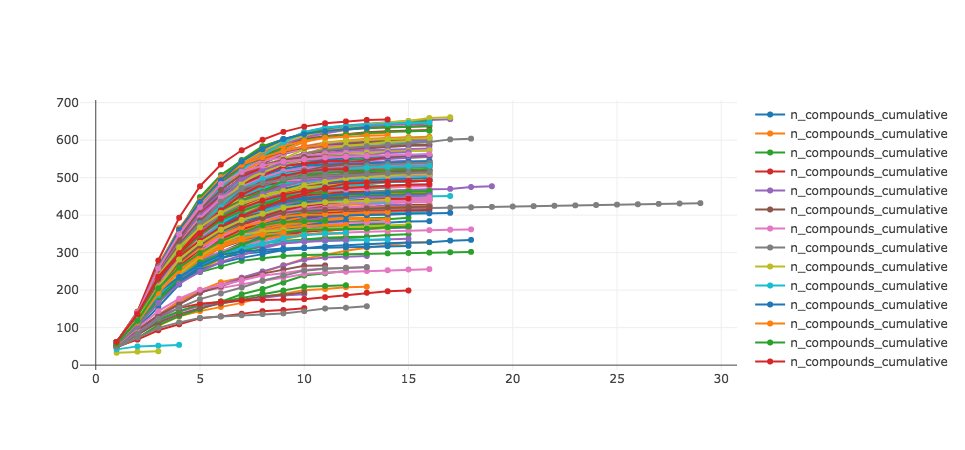

In [150]:
cool_plots_many(df,'n_compounds_cumulative')

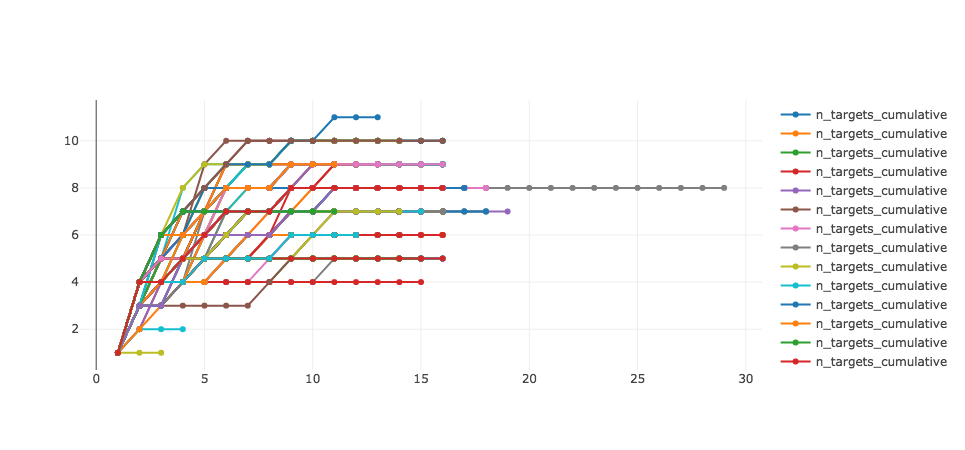

In [151]:
cool_plots_many(df,'n_targets_cumulative')

## - This lets me know that I need to start with targets and work backwards to try and figure out seeds necessary to produce those targets.

## Using all KEGGs reactions

In [154]:
INDIR = "../results/formatted/kegg_edge_json/"

generation_dfs, stats_dicts = read_formatted_json_single(INDIR)
# print len(generation_dfs)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = generation_dfs[0]

In [155]:
len(stats_dicts[0])

7

In [156]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C01326, C00132, C00067, C00014, C1150...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R05539, R09139, R00067, R00132, R0235...","[R10535, R10079, R10092, R00131, R09139, R0538...",[],[],18,18,23,23,0,0,reaction_edge,bacteria
2,"[C00001, C00080, C00007, C00026, C01326, C0013...","[C00080, C00007, C00026, C00288, C05359, C0002...","[R10092, R00608, R05539, R00279, R09139, R0006...","[R00608, R00279, R03546, R09144, R07803, R0478...",[],[],41,23,59,36,0,0,reaction_edge,bacteria
3,"[C00001, C00080, C00007, C00026, C00048, C0132...","[C00048, C00025, C00704, C00022, C00222, C0021...","[R00782, R10092, R00608, R00258, R05539, R0027...","[R00782, R00258, R00475, R00008, R01874, R0537...",[C00025],[C00025],67,26,147,88,1,1,reaction_edge,bacteria
4,"[C00001, C00080, C00007, C00026, C00048, C0132...","[C00036, C00546, C00097, C00037, C00065, C0006...","[R00340, R00363, R00782, R10092, R10178, R0060...","[R00340, R00363, R10178, R02914, R09648, R0156...","[C00025, C00097, C00037, C00065, C00064, C00041]","[C00097, C00037, C00065, C00064, C00041]",146,79,288,141,6,5,reaction_edge,bacteria
5,"[C00001, C00080, C00007, C02107, C00026, C0382...","[C02107, C03826, C00383, C02091, C00108, C0095...","[R00340, R09186, R10908, R03106, R03551, R0369...","[R09186, R10908, R03106, R03551, R03694, R0696...","[C00025, C00097, C00037, C00065, C00064, C0004...","[C00049, C00188]",244,98,393,105,8,2,reaction_edge,bacteria


(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 17.5,  17.6,  17.7,  17.8,  17.9,  18. ,  18.1,  18.2,  18.3,
         18.4,  18.5]),
 <a list of 10 Patch objects>)

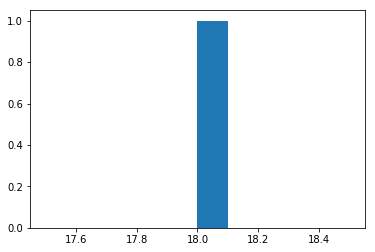

In [157]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 62.5,  62.6,  62.7,  62.8,  62.9,  63. ,  63.1,  63.2,  63.3,
         63.4,  63.5]),
 <a list of 10 Patch objects>)

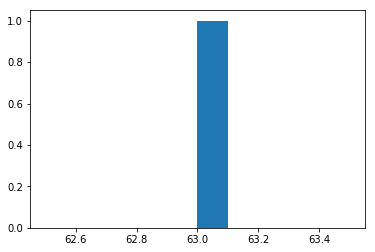

In [158]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 8278.5,  8278.6,  8278.7,  8278.8,  8278.9,  8279. ,  8279.1,
         8279.2,  8279.3,  8279.4,  8279.5]),
 <a list of 10 Patch objects>)

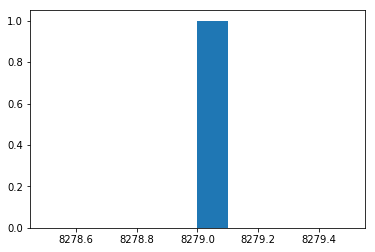

In [159]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 10286.5,  10286.6,  10286.7,  10286.8,  10286.9,  10287. ,
         10287.1,  10287.2,  10287.3,  10287.4,  10287.5]),
 <a list of 10 Patch objects>)

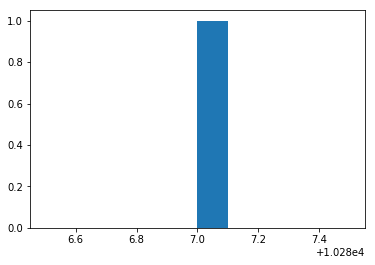

In [160]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

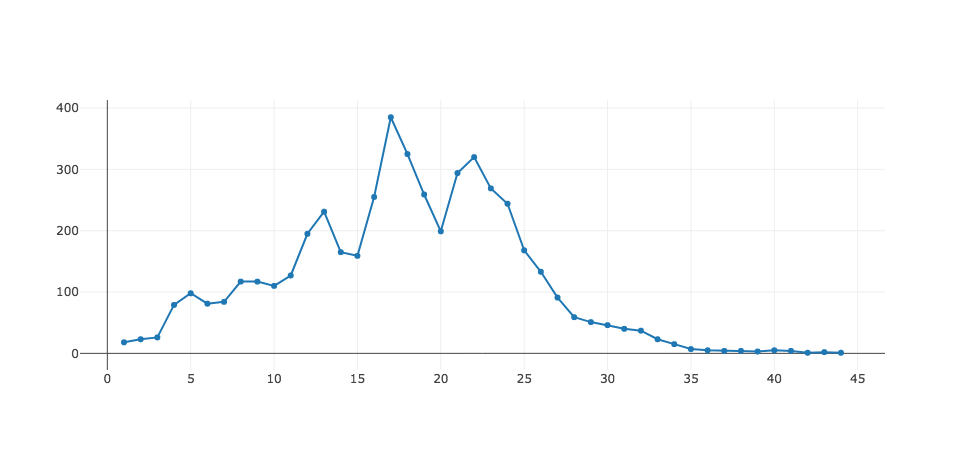

In [161]:
cool_plots_many(df,'n_compounds_new')

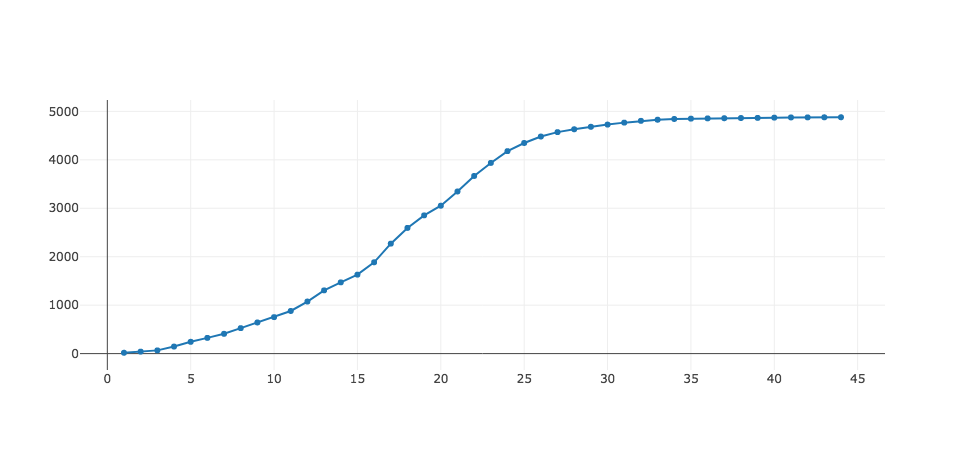

In [162]:
cool_plots_many(df,'n_compounds_cumulative')

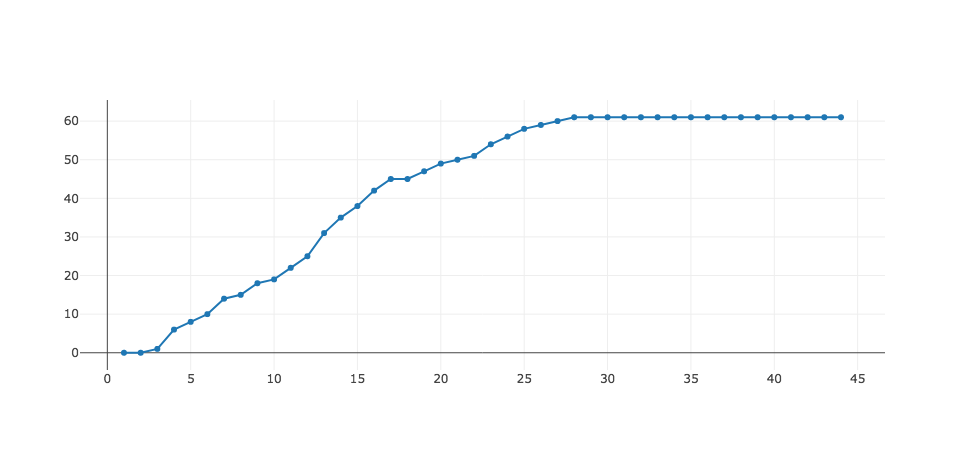

In [163]:
cool_plots_many(df,'n_targets_cumulative')

### Check if the targets columns were erroneous

#### Add map pathway data too?

#### Adding target data could be done post-processing as well

In [168]:
set(datajson["stats"]["scope_targets"])&set(generations["compounds_cumulative"][25])

set()

In [169]:
generations['compounds_cumulative'].apply(lambda x: [cpd for cpd in datajson["stats"]["scope_targets"] if cpd in x])


1     []
2     []
3     []
4     []
5     []
6     []
7     []
8     []
9     []
10    []
11    []
12    []
13    []
14    []
15    []
16    []
17    []
18    []
19    []
20    []
21    []
22    []
23    []
24    []
25    []
Name: compounds_cumulative, dtype: object

#### They don't appear to be.

## Plot

In [177]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top center'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

In [41]:
df["org_id"].unique()

array(['2506520044', '2506783009', '2517287024', '2529293002',
       '2529293211', '2531839260', '2554235474', '2554235476',
       '2554235477', '2554235490', '2554235497', '2718217646',
       '2718217664', '2718217665', '2718217666', '2718217667',
       '2721755430', '2721755431', '2721755892', '2721755895',
       '2724679803', '2728369738', '2739367758', '2740891997', '638154515',
       '644736411', '644736412', '650716079', '2515154133', '2515154138',
       '2515154140', '2515154141', '2515154152', '2517572146',
       '2518645608', '2518645611', '2519899518', '2521172661',
       '2523533532', '2523533546', '2523533611', '2523533612',
       '2524614558', '2524614663', '2524614672', '2524614757',
       '2524614857', '2524614862', '2524614884', '2540341173',
       '2546825502', '2546825503', '2558309102', '2563366730',
       '2565956515', '2565956590', '2571042909', '2574179701',
       '2574179723', '2574180435', '2574180450', '2582580728',
       '2582581268', '258258127

In [46]:
def cool_plots_many(df,attribute):
    traces = []
    for i in df["org_id"].unique():
        
        traces.append(go.Scatter(
        x = df.loc[df["org_id"]==i].index,
        y = df.loc[df["org_id"]==i][attribute],
        mode = 'lines+markers',
        name = attribute
        ))
    plotly.offline.iplot(traces)   

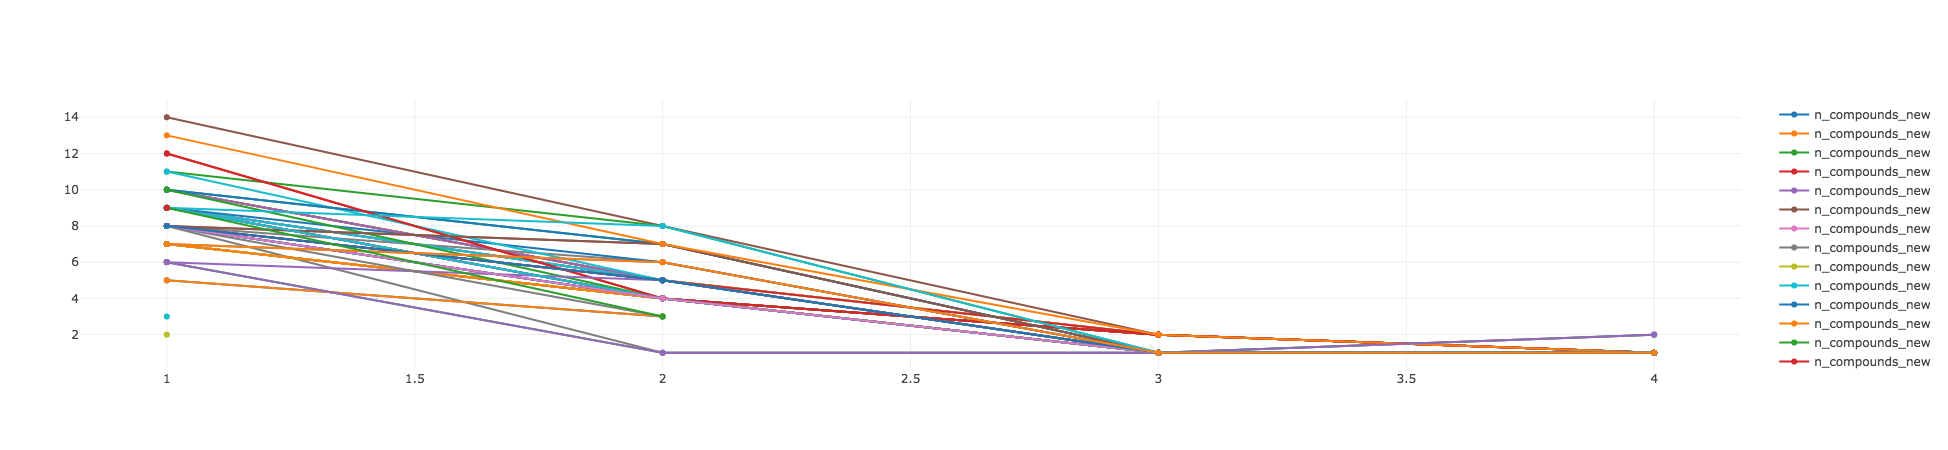

In [47]:
cool_plots_many(df,'n_compounds_new')

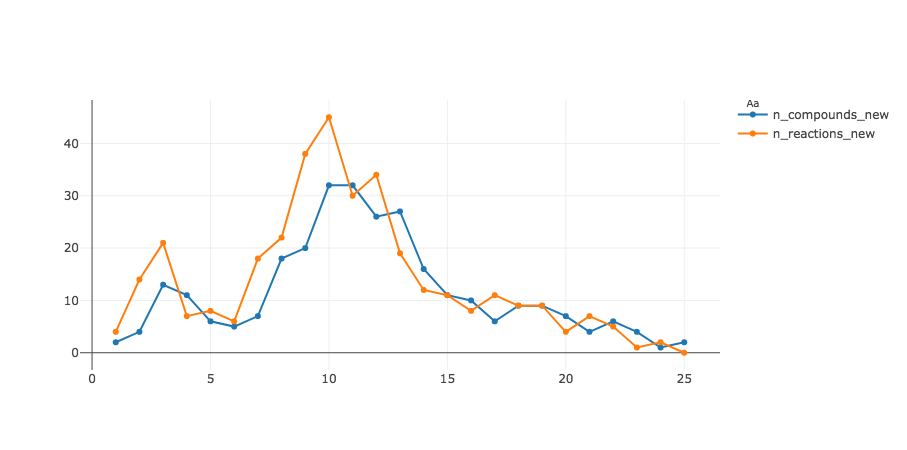

In [178]:
cool_plots(generations,'n_compounds_new','n_reactions_new')

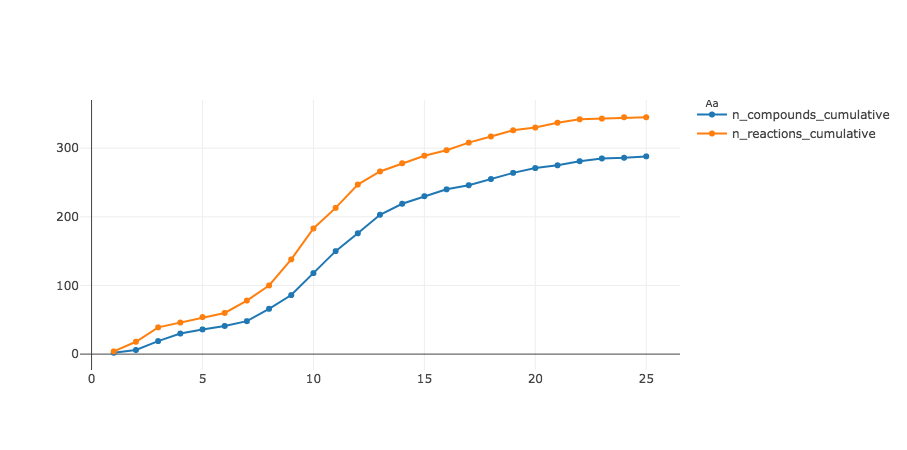

In [179]:
cool_plots(generations,'n_compounds_cumulative','n_reactions_cumulative')